In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import qcodes as qc
import os
from qcodes import (Measurement,
                    experiments,
                    initialise_database,
                    initialise_or_create_database_at,
                    load_by_guid,
                    load_by_run_spec,
                    load_experiment,
                    load_last_experiment,
                    load_or_create_experiment,
                    new_experiment,
                    ManualParameter)
import matplotlib.pyplot as plt

# db_name = "../offline_analysis/GeSiNW_Qubit_VTI01_Jonas_4.db" # Database name
db_name = "../data/GeSiNW_fully_autonomous_tuning.db" # Database name
sample_name = "Butch" # Sample name
exp_name = "Qubit_Search" # Experiment name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path
initialise_or_create_database_at(db_file_path)

experiment = load_or_create_experiment(experiment_name = exp_name,
                                       sample_name = sample_name)

plt.style.use('default')
import sys
sys.path.append('../')

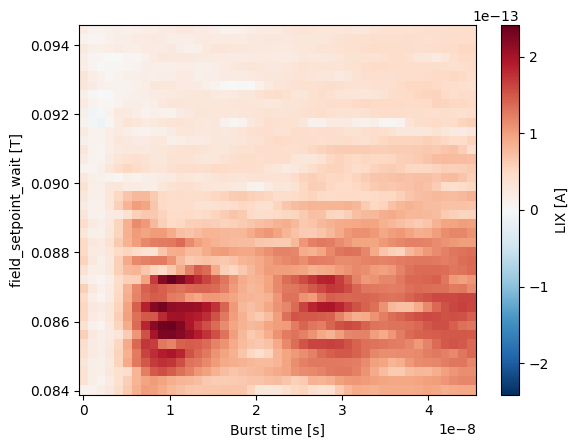

In [5]:
ds = load_by_guid('43c93b19-0000-0000-0000-018bb04dc88b')
ds.to_xarray_dataset()["LIX"].plot()
data = ds.to_xarray_dataset()

/var/folders/yr/fc8y5h9x6vz1qk9l1qyhm_3h0000gr/T/ipykernel_53326/3440726153.py:11: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pca = PCA(lix, liy)


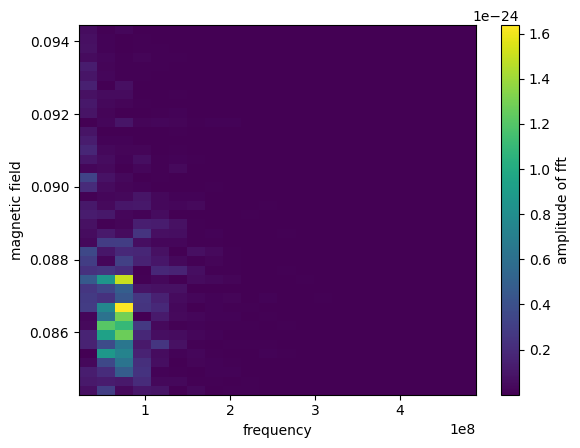

magnetic_field_max: 0.0864222309990149, rabi_frequ:66666666.66666666


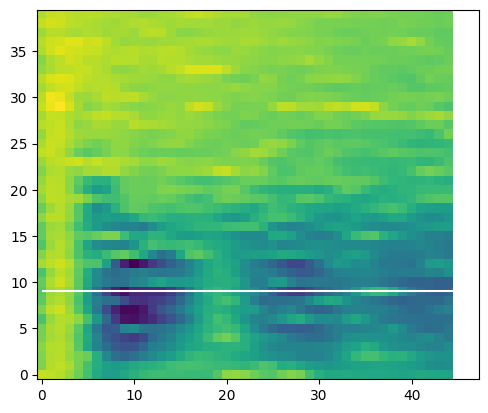

In [13]:

from data_visualisation.utils import PCA

key_magnet = list(dict(data.dims).keys())[0]
key_burst_times = list(dict(data.dims).keys())[1]
burst_times = data[key_burst_times].to_numpy()
magnetic_fields = data[key_magnet].to_numpy()

lix = data['LIX']
liy = data['LIY']

pca = PCA(lix, liy)
from scipy.fft import rfft as _rfft
from scipy.fft import rfftfreq

number_of_samples = len(burst_times)
total_time = burst_times[-1]
sample_rate = number_of_samples / total_time

out = [rfftfreq(number_of_samples, 1 / sample_rate), _rfft(pca)]
frequency, amplitudes = out

real_amplitudes = []
for amplitude in amplitudes:
    amplitude = amplitude[1:]
    real_amplitudes.append(amplitude * np.conj(amplitude))
    # plt.plot(frequency[1:],amplitude*np.conj(amplitude))
    # max_amplitudes.append(np.max(amplitude))
fig = plt.figure()
plt.imshow(np.real(real_amplitudes),
           extent=[
               frequency[1],
               frequency[-1],
               magnetic_fields[1],
               magnetic_fields[-1]
           ],
           origin='lower',
           aspect='auto')
plt.ylabel('magnetic field')
plt.xlabel('frequency')
plt.colorbar(label='amplitude of fft')
plt.show()
magnetic_field_max_idx, rabi_frequ_idx = np.unravel_index(np.argmax(real_amplitudes),
                                                          np.array(real_amplitudes).shape)
magnetic_field_max = magnetic_fields[magnetic_field_max_idx]
rabi_frequ = frequency[rabi_frequ_idx + 1]
message = f'magnetic_field_max: {magnetic_field_max}, rabi_frequ:{rabi_frequ}'
print(message)
plt.imshow(pca, origin='lower', )
plt.hlines(magnetic_field_max_idx, 0, pca.shape[1], colors='white')
plt.show()
